In [1]:
from google.colab import files
import numpy as np

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input # из кераса загружаем необходимые слои для нейросети
from tensorflow.keras.optimizers import RMSprop, Adadelta # из кераса загружаем выбранный оптимизатор
from tensorflow.keras.preprocessing.sequence import pad_sequences # загружаем метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.text import Tokenizer # загружаем токенизатор кераса для обработки текста
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model

import yaml # импортируем модуль для удобной работы с файлами

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Парсинг данных**

In [4]:
corpus = open('/content/Диалоги(рассказы)_censored.yml', 'r') # открываем файл с диалогами в режиме чтения
document = yaml.safe_load(corpus) # загружаем файл *глоссарий
conversations = document['разговоры'] # загружаем диалоги из файла и заносим в conversations 
print('Количество пар вопрос-ответ : {}'.format(len(conversations)))
print('Пример диалога : {}'.format(conversations[123]))
corpus.close()

Количество пар вопрос-ответ : 11893
Пример диалога : ['Перезалил?', 'Да вроде бы нет...']


In [5]:
# Разбираем вопросы-ответы с проставлением тегов ответам

questions = list() #список вопросов
answers = list() # список ответов


for con in conversations: # для каждой пары вопрос-ответ
  if len(con) > 2 : # если ответ содержит более двух предложений (кол-во реплик, кол-во вариантов ответа)
    questions.append(con[0])
    replies = con[1:] 
    ans = ''
    for rep in replies:
      ans += ' ' + rep 
    answers.append(ans)
  elif len(con)> 1: # если на 1 вопрос приходится 1 ответ
    questions.append(con[0])
    answers.append(con[1])

# Очищаем строки с неопределенным типом ответов
answersCleaned = list()
for i in range(len(answers)):
  if type(answers[i]) == str:
    answersCleaned.append(answers[i])
  else:
    questions.pop(i) 


answers = list()
for i in range(len(answersCleaned)):
  answers.append( '<START> ' + answersCleaned[i] + ' <END>' )


print('Вопрос : {}'.format(questions[200]))
print('Ответ : {}'.format(answers[200]))

Вопрос : Около сотни...
Ответ : <START> Точнее! <END>


In [6]:
# Cобираем словарь индексов

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions + answers)
vocabularyItems = list(tokenizer.word_index.items())
vocabularySize = len(vocabularyItems)+1
print( 'Фрагмент словаря : {}'.format(vocabularyItems[:50]))
print( 'Размер словаря : {}'.format(vocabularySize))

Фрагмент словаря : [('start', 1), ('end', 2), ('что', 3), ('не', 4), ('я', 5), ('а', 6), ('ты', 7), ('это', 8), ('да', 9), ('в', 10), ('нет', 11), ('как', 12), ('и', 13), ('вы', 14), ('ну', 15), ('с', 16), ('на', 17), ('же', 18), ('так', 19), ('он', 20), ('у', 21), ('кто', 22), ('где', 23), ('все', 24), ('мы', 25), ('то', 26), ('мне', 27), ('тебя', 28), ('меня', 29), ('здесь', 30), ('еще', 31), ('почему', 32), ('о', 33), ('тебе', 34), ('там', 35), ('есть', 36), ('его', 37), ('за', 38), ('куда', 39), ('вот', 40), ('ничего', 41), ('вас', 42), ('знаю', 43), ('чем', 44), ('но', 45), ('она', 46), ('они', 47), ('ли', 48), ('чего', 49), ('вам', 50)]
Размер словаря : 15092


# **Подготовка выборки**


In [7]:
tokenizedQuestions = tokenizer.texts_to_sequences(questions) # разбиваем текст вопросов на последовательности индексов
maxLenQuestions = max([ len(x) for x in tokenizedQuestions])
paddedQuestions = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')

encoderForInput = paddedQuestions
print('Пример оригинального вопроса на вход : {}'.format(questions[100])) 
print('Пример кодированного вопроса на вход : {}'.format(encoderForInput[100])) 
print('Размеры закодированного массива вопросов на вход : {}'.format(encoderForInput.shape)) 
print('Установленная длина вопросов на вход : {}'.format(maxLenQuestions)) 


Пример оригинального вопроса на вход : Какая же мораль?
Пример кодированного вопроса на вход : [ 170   18 5703    0    0    0    0    0    0    0    0]
Размеры закодированного массива вопросов на вход : (11888, 11)
Установленная длина вопросов на вход : 11


In [8]:
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
maxLenAnswers = max([len(x) for x in tokenizedAnswers])
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers, padding='post')

# Предподготавливаем данные для входа в сеть
decoderForInput = paddedAnswers # переводим в numpy массив
print('Пример оригинального ответа на вход: {}'.format(answers[100])) 
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[200])) 
print('Размеры раскодированного массива ответов на вход : {}'.format(decoderForInput.shape)) 
print('Установленная длина ответов на вход : {}'.format(maxLenAnswers)) 

Пример оригинального ответа на вход: <START> Никакой. Так просто вспомнилось. <END>
Пример раскодированного ответа на вход : [   1 1743    2    0    0    0    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на вход : (11888, 13)
Установленная длина ответов на вход : 13


In [ ]:
tokenizedAnswers = tokenizer.texts_to_sequences(answers) # разбиваем текст ответов на последовательности индексов
for i in range(len(tokenizedAnswers)) : 
  tokenizedAnswers[i] = tokenizedAnswers[i][1:] 
paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

oneHotAnswers = utils.to_categorical(paddedAnswers, vocabularySize) # переводим в one hot vector
decoderForOutput = np.array(oneHotAnswers) # и сохраняем в виде массива numpy

In [ ]:
print('Пример раскодированного ответа на вход : {}'.format(decoderForInput[100][:21]))  
print('Пример раскодированного ответа на выход : {}'.format(decoderForOutput[100][4][:21])) 
print('Размеры раскодированного массива ответов на выход : {}'.format(decoderForOutput.shape))
print('Установленная длина вопросов на выход : {}'.format(maxLenAnswers)) 

Пример раскодированного ответа на вход : [    1   673    19    93 10558     2     0     0     0     0     0     0
     0]
Пример раскодированного ответа на выход : [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Размеры раскодированного массива ответов на выход : (11900, 13, 15104)
Установленная длина вопросов на выход : 13


# **Параметры нейросети и модель обучения**


In [ ]:
encoderInputs = Input(shape=(None , )) # размеры на входе сетки (здесь будет encoderForInput)
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

In [ ]:
decoderInputs = Input(shape=(None, )) # размеры на входе сетки (здесь будет decoderForInput)
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM (decoderEmbedding, initial_state=encoderStates)
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense (decoderOutputs)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    3018400     input_9[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, None, 200)    3018400     input_10[0][0]                   
____________________________________________________________________________________________

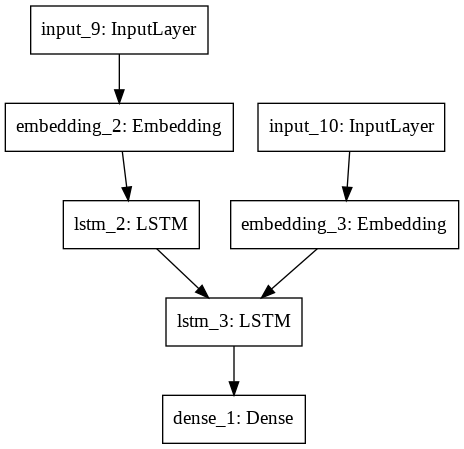

In [ ]:
model = Model([encoderInputs, decoderInputs], output)
model.compile(optimizer=RMSprop(), loss='categorical_crossentropy')

print(model.summary())
plot_model(model, to_file='model.png')

In [ ]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=2) 
#model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms).h5' )

Epoch 1/2
238/238 [==============================] - 38s 129ms/step - loss: 2.4882
Epoch 2/2
238/238 [==============================] - 31s 130ms/step - loss: 1.9709


In [ ]:
model.compile(optimizer=Adadelta(), loss='categorical_crossentropy')

In [ ]:
model.fit([encoderForInput , decoderForInput], decoderForOutput, batch_size=50, epochs=2) 
model.save( '/content/drive/My Drive/Предобученные сети/model_100epochs(rms) + 50(ada).h5' )

Epoch 1/2
238/238 [==============================] - 38s 127ms/step - loss: 4.0082
Epoch 2/2
238/238 [==============================] - 28s 117ms/step - loss: 4.0044


In [ ]:
model.load_weights('/content/drive/My Drive/Предобученные сети/model_100epochs(rms) + 50(ada).h5')

# **Подготовка и запуск рабочей нейросети с генерацией ответов**


In [ ]:
# Создаем рабочую модель для вывода ответов на запросы пользователя
def makeInferenceModels():
  encoderModel = Model(encoderInputs, encoderStates) 
  decoderStateInput_h = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_h
  decoderStateInput_c = Input(shape=(200 ,)) # обозначим размерность для входного слоя с состоянием state_c

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c]

  # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 
  decoderOutputs = decoderDense(decoderOutputs) 
  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

  return encoderModel , decoderModel

In [ ]:
def strToTokens(sentence: str):
  words = sentence.lower().split()
  tokensList = list()
  for word in words:
    tokensList.append(tokenizer.word_index[word])
  # Функция вернёт вопрос в виде последовательности индексов, ограниченной длиной самого длинного вопроса из нашей базы вопросов
  return pad_sequences([tokensList], maxlen=maxLenQuestions , padding='post')

In [ ]:
encModel , decModel = makeInferenceModels() # запускаем функцию для построения модели кодера и декодера

for _ in range(3):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start']

  stopCondition = False
  decodedTranslation = ''
  while not stopCondition : # пока не сработало стоп-условие
    # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
    # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :])
    sampledWord = None
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: # если индекс выбранного слова соответствует какому-то индексу из словаря
        decodedTranslation += ' {}'.format(word)
        sampledWord = word

    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True # срабатывает стоп-условие и прекращаем генерацию

    emptyTargetSeq[0, 0] = sampledWordIndex
    statesValues = [h, c]
  
  print(decodedTranslation[:-3])

Задайте вопрос : привет
 что тебе надо человек 
Задайте вопрос : зачем ты здесь
 я хотела посмотреть на посмотреть на что я два 
Задайте вопрос : сколько тебе лет
 не знаю а сколько нужно 


# **Загрузка и запуск предобученной модели**


In [ ]:
model = load_model('/content/drive/MyDrive/Базы/model_chatbot_100epochs(rms)+50(ada).h5')
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 200)    3020800     input_1[0][0]                    
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 200)    3020800     input_2[0][0]                    
____________________________________________________________________________________________

In [ ]:
def loadInferenceModels():
  encoderInputs = model.input[0]
  encoderEmbedding = model.layers[2]
  encoderOutputs, state_h_enc, state_c_enc = model.layers[4].output 
  encoderStates = [state_h_enc, state_c_enc]
  encoderModel = Model(encoderInputs, encoderStates)

  decoderInputs = model.input[1] 
  decoderStateInput_h = Input(shape=(200 ,))
  decoderStateInput_c = Input(shape=(200 ,))

  decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

  decoderEmbedding = model.layers[3]
  decoderLSTM = model.layers[5] 
  decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding.output, initial_state=decoderStatesInputs)
  decoderStates = [state_h, state_c] 

  decoderDense = model.layers[6] 
  decoderOutputs = decoderDense(decoderOutputs) 

  decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)
  return encoderModel , decoderModel

In [ ]:
encModel , decModel = loadInferenceModels()

for _ in range(6):
  statesValues = encModel.predict(strToTokens(input( 'Задайте вопрос : ' )))
  emptyTargetSeq = np.zeros((1, 1))    
  emptyTargetSeq[0, 0] = tokenizer.word_index['start'] 

  stopCondition = False 
  decodedTranslation = '' 
  while not stopCondition : 
    decOutputs , h , c = decModel.predict([emptyTargetSeq] + statesValues)
    
    sampledWordIndex = np.argmax( decOutputs[0, 0, :]) 
    sampledWord = None 
    for word , index in tokenizer.word_index.items():
      if sampledWordIndex == index: 
        decodedTranslation += ' {}'.format(word) 
        sampledWord = word 
    
    if sampledWord == 'end' or len(decodedTranslation.split()) > maxLenAnswers:
      stopCondition = True 

    emptyTargetSeq = np.zeros((1, 1)) 
    emptyTargetSeq[0, 0] = sampledWordIndex 
    statesValues = [h, c] 
  
  print(decodedTranslation[:-3]) 

Задайте вопрос : привет
 с господин это не 
Задайте вопрос : как дела
 за ночь сделали вставай мотор 
Задайте вопрос : кто ты
 ты ник меня отец 
Задайте вопрос : сколько тебе лет
 двадцать ваше 
Задайте вопрос : кто твой отец
 да я не 
Задайте вопрос : когда домой
 сейчас очень просто что же 
